In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import model.GSF as fs
from model.GSF import FSTSFModel
from utils import Modeltools
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from utils.Modeltools import metrics_3
from utils.Modeltools import FiguresDisply
from utils.Modeltools import cacluationError_BestFV
from utils.Modeltools import BPreAndTrue
from utils.Modeltools import FiguresDisply_Comparison
from data.data_provider import data_provider

In [5]:
class experiment1():
    
    def __init__(self, args):
        
        self.args = args
        self._get_data()
        self.name = '{}-{}-{}-{}'.format(args.Data,args.Pre_len,args.SNumber,args.Treetype)

    def _get_forecasting(self):
    
        return self.forecastingResultsByFT,self.forecastingResultsByKDE
    
    def _get_data(self):
        
        self.SoomthedTrainData,self.SaclertrainData,self.OringalTrainData,self.TrueData,self.allOD,self.sacleFuntion = data_provider(self.args) #data_provider(self.args, flag)
        
    def _errors(self):
        
        if self.sacleFuntion:
            print('Maxmin')
            inverseFV1 = self.sacleFuntion.inverse_transform(np.array(self.FinalForecastingResults_1).reshape(-1,1)).reshape(-1,)
            inverseFV2 = self.sacleFuntion.inverse_transform(np.array(self.FinalForecastingResults_2).reshape(-1,1)).reshape(-1,)
            self.inverseFV3 = self.sacleFuntion.inverse_transform(np.array(self.FinalForecastingResults_3).reshape(-1,1)).reshape(-1,)
            FiveForecasting = self.sacleFuntion.inverse_transform(np.array(self.FiveForecasting).reshape(5,-1)).reshape(5,-1)

        else:
            inverseFV1 =self.FinalForecastingResults_1
            inverseFV2 =self.FinalForecastingResults_2
            self.inverseFV3 =self.FinalForecastingResults_3
            FiveForecasting = self.FiveForecasting
        if self.args.Data == 'USE':
            TBP,Mr2,Mmae,Mmse = cacluationError_BestFV(FiveForecasting,self.TrueData.tolist(),self.args.Pre_len,True)
        else:
            TBP,Mr2,Mmae,Mmse = cacluationError_BestFV(FiveForecasting,self.TrueData.tolist(),self.args.Pre_len,True)
            
        metrics_3([inverseFV1],self.TrueData,True,'Final Forecasting')
        self.FiveFbest = FiveForecasting[TBP]
            
        FiguresDisply([self.TrueData,self.FiveFbest,self.inverseFV3],['True','GSF (Five)','GS (Final)'],True,self.name)
        FiguresDisply_Comparison([self.FiveFbest,self.inverseFV3,self.allOD[:len(self.inverseFV3)+len(self.SoomthedTrainData)]],['GS (Five)','GS (Final)','True'],self.name)
            
    def train(self):
        
        self.Model = fs.FSTSFModel(self.SoomthedTrainData,self.SaclertrainData,self.args)
        self.forecastingResultsByFT,self.forecastingResultsByKDE = self.Model.trainModelAndKDEresults() 
        
    def filter(self):
        
        if self.args.Scale:
             
            self.FiveForecasting,self.FinalForecastingResults_1,self.FirstHalfForecasting,self.FinalForecastingResults_2,self.LastHalfForecasting,self.FinalForecastingResults_3,self.MaxMinForecasting,self.GSPS,self.PBS,self.RA,self.RASS = self.Model.BackwardFiltering(self.TrueData.tolist(),self.OringalTrainData)

        else:
            
            self.FiveForecasting,self.FinalForecastingResults_1,self.FirstHalfForecasting,self.FinalForecastingResults_2,self.LastHalfForecasting,self.FinalForecastingResults_3,self.MaxMinForecasting,self.GSPS,self.PBS,self.RA,self.RASS = self.Model.BackwardFiltering(self.TrueData)


In [11]:
# def args():
def Ex1(name):
    
    if name == "USE":
        
        Horizon = [100]
        SNumber= [6]
        
        for i in range(len(Horizon)):
            
            parser = argparse.ArgumentParser(description='FSTLmodel_')
            #FT model
            parser.add_argument('--Pre_len', type=int, default=Horizon[i], help='prediction sequence length')
            parser.add_argument('--RDY', type=int, default=0, help='1 is regular data, and 0 is irregular data')
            parser.add_argument('--SNumber', type=int, default=SNumber[i], help='the distance of peak points')
            parser.add_argument('--Display', type=str, default=False, help='whether return the results')
            parser.add_argument('--Treetype', type=str, default='BT', help='the used data')
            parser.add_argument('--Noice', type=str, default=True, help='the used data')

            #data
            parser.add_argument('--Data', type=str, default='USE',help='the used data(USE,WindSpeed,Sunspots,SunPower)')
            parser.add_argument('--Scale', type=str, default=False,help='the used data(USE,WP,SUNP,SUNS)')
            parser.add_argument('--Smoothing', type=str, default=False,help='wether smooth the data')
            args = parser.parse_args(args=[])
            
            print(args)
            ex1 = experiment1(args)
            ex1.train()
            ex1.filter()
            ex1._errors()
            
    elif name == "WindSpeed":
        
        Horizon = [300]
        SNumber= [25]
        
        for i in range(len(Horizon)):
            
            parser = argparse.ArgumentParser(description='FSTLmodel_')
            #FT model
            parser.add_argument('--Pre_len', type=int, default=Horizon[i], help='prediction sequence length')
            parser.add_argument('--RDY', type=int, default=0, help='1 is regular data, and 0 is irregular data')
            parser.add_argument('--SNumber', type=int, default=SNumber[i], help='the distance of peak points')
            parser.add_argument('--Display', type=str, default=False, help='whether return the results')
            parser.add_argument('--Treetype', type=str, default='BT', help='the used data')
            parser.add_argument('--Noice', type=str, default=True, help='the used data')

            #data
            parser.add_argument('--Data', type=str, default='WindSpeed',help='the used data(USE,WindSpeed,Sunspots,SunPower)')
            parser.add_argument('--Scale', type=str, default=True,help='the used data(USE,WP,SUNP,SUNS)')
            parser.add_argument('--Smoothing', type=str, default=False,help='wether smooth the data')
            args = parser.parse_args(args=[])
            
            print(args)
            ex1 = experiment1(args)
            ex1.train()
            ex1.filter()
            ex1._errors()

    elif name=='SunSpots':
    
        Horizon = [600] #
        SNumber= [12] #
        
        for i in range(len(Horizon)):
            
            parser = argparse.ArgumentParser(description='FSTLmodel_')
            #FT model
            parser.add_argument('--Pre_len', type=int, default=Horizon[i], help='prediction sequence length')
            parser.add_argument('--RDY', type=int, default=1, help='1 is regular data, and 0 is irregular data')
            parser.add_argument('--SNumber', type=int, default=SNumber[i], help='the distance of peak points')
            parser.add_argument('--Display', type=str, default=False, help='whether return the results')
            parser.add_argument('--Treetype', type=str, default='BT', help='the used data')
            parser.add_argument('--Noice', type=str, default=True, help='the used data')

            #data
            parser.add_argument('--Data', type=str, default='SunSpots',help='the used data(USE,WindSpeed,Sunspots,SunPower)')
            parser.add_argument('--Scale', type=str, default=True,help='the used data(USE,WP,SUNP,SUNS)')
            parser.add_argument('--Smoothing', type=str, default=False,help='wether smooth the data')
            args = parser.parse_args(args=[])
            
            print(args)
            ex1 = experiment1(args)
            ex1.train()
            ex1.filter()
            ex1._errors()

    elif name=='SunPower':
    
        USE_Horizon = [500] 
        SNumber= [40] 
        
        for i in range(len(USE_Horizon)):
            
            parser = argparse.ArgumentParser(description='FSTLmodel_')
            #FT model
            parser.add_argument('--Pre_len', type=int, default=USE_Horizon[i], help='prediction sequence length')
            parser.add_argument('--RDY', type=int, default=1, help='1 is regular data, and 0 is irregular data')
            parser.add_argument('--SNumber', type=int, default=SNumber[i], help='the distance of peak points')
            parser.add_argument('--Display', type=str, default=False, help='whether return the results')
            parser.add_argument('--Treetype', type=str, default='BT', help='the used data')
            parser.add_argument('--Noice', type=str, default=True, help='the used data')

            #data
            parser.add_argument('--Data', type=str, default='SunPower',help='the used data(USE,WindSpeed,Sunspots,SunPower)')
            parser.add_argument('--Scale', type=str, default=True,help='the used data(USE,WP,SUNP,SUNS)')
            parser.add_argument('--Smoothing', type=str, default=False,help='wether smooth the data')
            args = parser.parse_args(args=[])
            
            print(args)
            ex1 = experiment1(args)
            ex1.train()
            ex1.filter()
            ex1._errors()


Namespace(Pre_len=500, RDY=1, SNumber=40, Display=False, Treetype='BT', Noice=True, Data='SunPower', Scale=True, Smoothing=False)
Scale
Maxmin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of forecasting results: 5
The best result: VR2 0.5097551118100627 | R2 0.3351165652706941 | MSE 78818.47273124149 | MAE 221.31386963583685 | Indexs: 3 3 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The result by Final Forecasting
MAE:215.34320862411707 |MSE:73574.36175335737 |MAPE:1.0958800234821506 |R2:0.3793539426043864 |VR2:0.4828248706058548
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


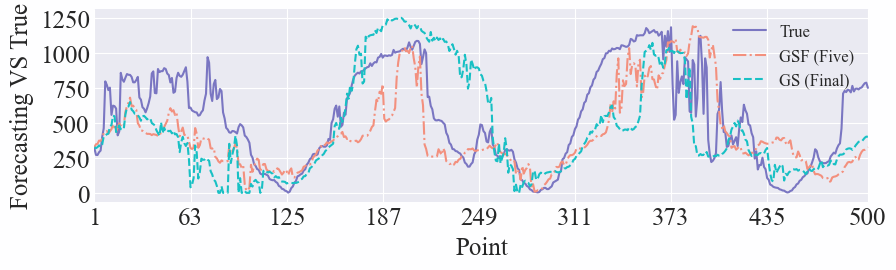

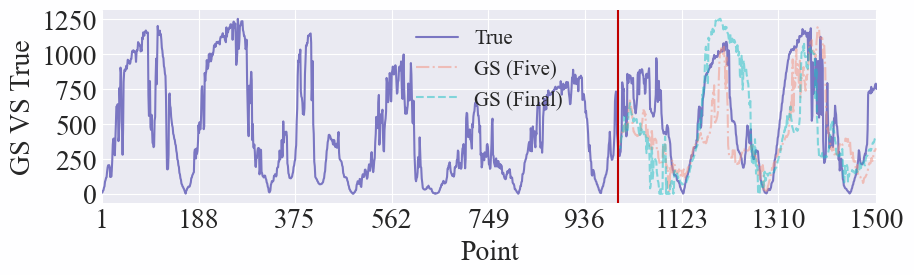

In [7]:
Ex1("SunPower")

Namespace(Pre_len=600, RDY=1, SNumber=12, Display=False, Treetype='BT', Noice=True, Data='SunSpots', Scale=True, Smoothing=False)
Scale
Maxmin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of forecasting results: 5
The best result: VR2 0.6218909157237315 | R2 0.13755355643783718 | MSE 7.120007085871988 | MAE 2.110837937533944 | Indexs: 4 4 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The result by Final Forecasting
MAE:2.4918569739618652 |MSE:10.277498409549928 |MAPE:0.36963644972325493 |R2:-0.2449133610583436 |VR2:0.8086669284933345
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


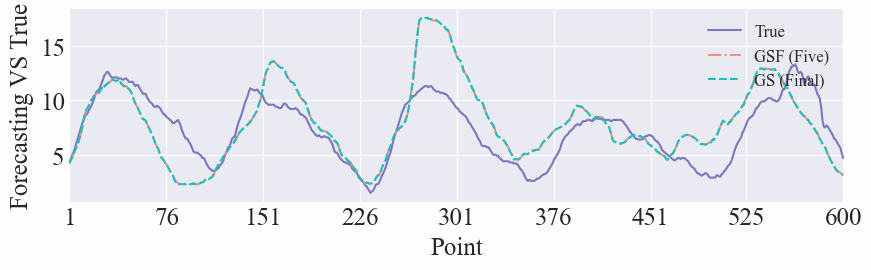

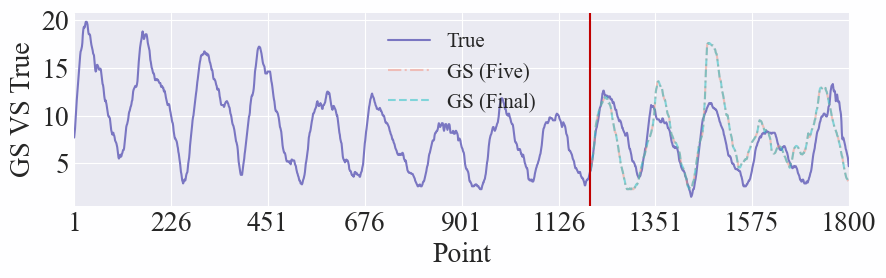

In [8]:
Ex1("SunSpots")

Namespace(Pre_len=100, RDY=0, SNumber=6, Display=False, Treetype='BT', Noice=True, Data='USE', Scale=False, Smoothing=False)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of forecasting results: 5
The best result: VR2 0.30850131812768444 | R2 0.6386166959765667 | MSE 0.0022358828173288364 | MAE 0.040272683256153234 | Indexs: 0 0 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The result by Final Forecasting
MAE:0.05740490285968354 |MSE:0.0048352019867899795 |MAPE:0.07142553047950428 |R2:0.2184915702807857 |VR2:0.5774604378623899
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


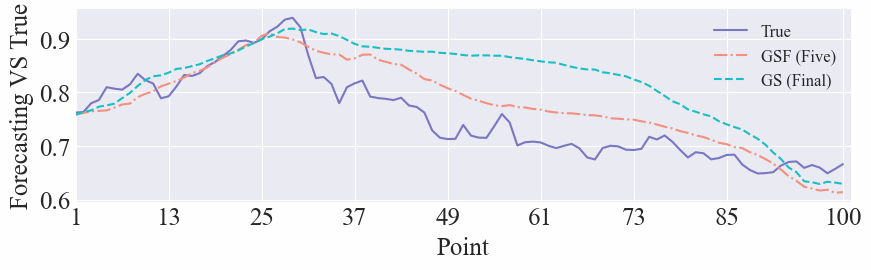

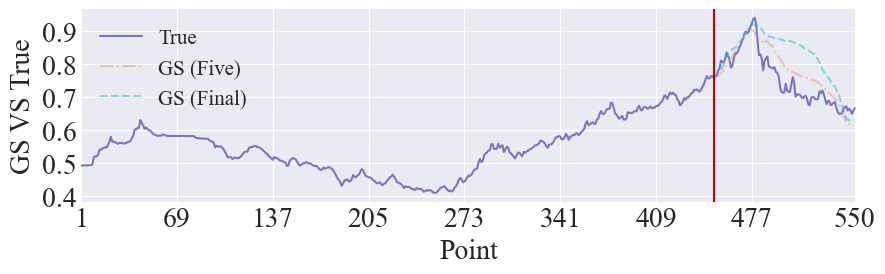

In [12]:
Ex1("USE")

Namespace(Pre_len=300, RDY=0, SNumber=25, Display=False, Treetype='BT', Noice=True, Data='WindSpeed', Scale=True, Smoothing=False)
Scale
Maxmin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of forecasting results: 5
The best result: VR2 0.4253471369480109 | R2 0.46987851081503906 | MSE 2.849694436301749 | MAE 1.275241739873834 | Indexs: 0 0 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The result by Final Forecasting
MAE:1.489660176061406 |MSE:4.0529277608499505 |MAPE:0.14777368982970798 |R2:0.246044041504617 |VR2:0.5618737844530989
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


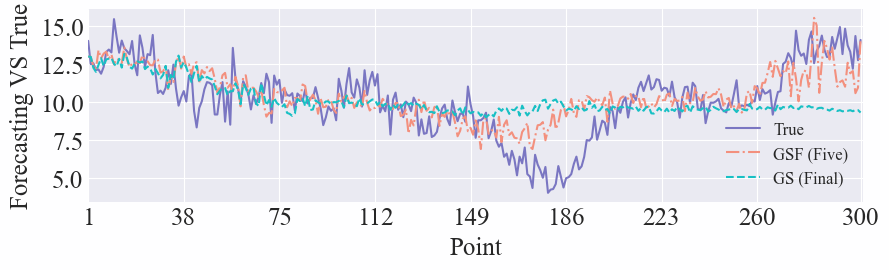

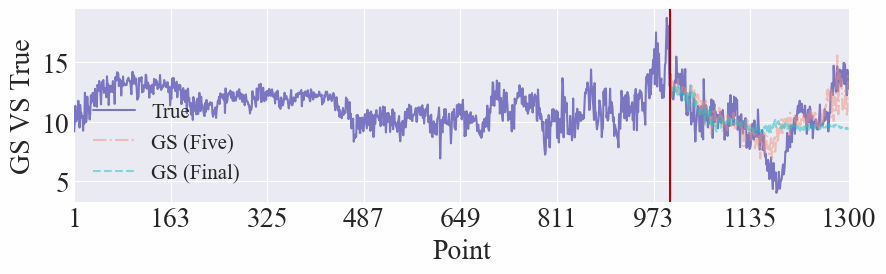

In [10]:
Ex1("WindSpeed")